In [1]:
import numpy as np
import pandas as pd
from datetime import date

from sklearn import cluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

import re
import os

import nltk
import string

In [54]:
#Загружаем грязные данные
data = pd.read_csv("Data.csv")

data['index'] = range(1, len(data) + 1)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104413 entries, 0 to 104412
Data columns (total 6 columns):
dept_code     104413 non-null object
issue_date    104329 non-null object
issuer        104329 non-null object
issuer_eng    104329 non-null object
values;;      104329 non-null object
index         104413 non-null int32
dtypes: int32(1), object(5)
memory usage: 4.4+ MB


In [8]:
# Очистка данных
data['failed'] = data['dept_code'].str.contains(';', regex=True)
data[data['failed'] == True]
data = data[data['failed'] == False]
del data['failed']
data['year'] = data['issue_date'].dt.strftime('%Y')
data.head()

,dept_code,issue_date,issuer,issuer_eng,values;;,index,year
0,20003,2001-11-05,ОУФМС,OUFMS,20003_345;;,1,2001
1,20003,2002-03-22,МВД ПО РЕСПУБЛИКЕ БАШКОРТОСТАН,MVD PO RESPUBLIKE BASHKORTOSTAN,20003_319;;,2,2002
2,20003,2002-05-18,МВД ПО РЕСПУБЛИКЕ БАШКОРТОСТАН,MVD PO RESPUBLIKE BASHKORTOSTAN,20003_319;;,3,2002
3,20003,2002-08-13,ОТДЕЛОМ УФМС РОССИИ ПО РЕСПУБЛИКЕ БАШКОРТОСТАН...,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...,20003_346;;,4,2002
4,20003,2003-07-17,ОТДЕЛОМ УФМС РОССИИ ПО РЕСПУБЛИКЕ БАШКОРТОСТАН...,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...,20003_347;;,5,2003


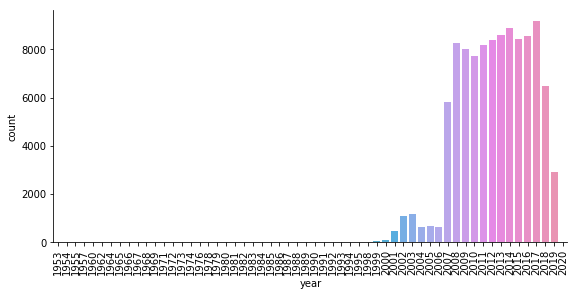

In [9]:
#Определяем год, скоторого можно анализировать выборку
g = sns.factorplot("year", data=data, aspect=2, kind="count")
g.set_xticklabels(rotation=90)

In [57]:
#Обрезаем и обрабатываем данные
data['issue_date']= pd.to_datetime(data['issue_date'])
data = data[data['issue_date'].dt.strftime('%Y') >= '2001']
data["issuer_eng"]=data['issuer_eng'].map(str.upper)

In [42]:
#Будем определять точность кластеризации на одном регионе
d_20024 = data[data['dept_code'] == '20024']
documents = d_20024['issuer_eng'].values.astype("U")
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)
features = vectorizer.fit_transform(documents)

In [43]:
#Подбираем оптимальное значение k
Sum_of_squared_distances = []
K = range(2,5)

for k in K:
   km = KMeans(n_clusters=k, max_iter=100, n_init=1)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)

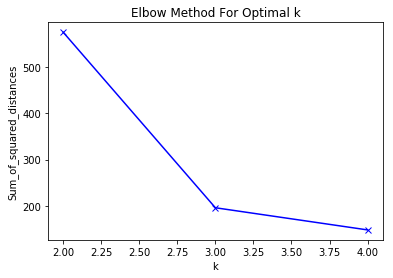

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
plt.savefig('k.png')

In [45]:
#Строим модель кластеризации
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
d_20024['cluster'] = model.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [48]:
#Выявляем центры кластеров
dg = d_20024.groupby(['cluster', 'issuer_eng'], sort=False).agg('count')
dg = d_20024.groupby(['dept_code', 'cluster', 'issuer_eng']).count()[['issue_date']]
dg.reset_index(inplace=True)
dg_max = dg.groupby(['dept_code', 'cluster']).max()[['issue_date']]
dg_max.reset_index(inplace=True)
grouped = pd.merge(dg_max, dg, how='inner')
dg_max.head()

,dept_code,cluster,issue_date
0,20024,0,1849
1,20024,1,244
2,20024,2,699


In [28]:
#Центрами разных кластеров оказались очень похожие друг на друга значения
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
 
for i in range(true_k):
     print("Cluster %d:" % i, end='')
     for ind in order_centroids[i, :11]:
         print(' %s' % terms[ind], end='')
         print()

Top terms per cluster:
Cluster 0: gor
 otdelom
 rajone
 kalininskom
 ufy
 rossii
 ufms
 respublike
 bashkortostan
 po
 respubliki
Cluster 1: goroda
 otdelom
 kalininskom
 rajone
 ufms
 rossii
 ufy
 respublike
 bashkortostan
 po
 otdel
Cluster 2: mvd
 respublike
 bashkortostan
 po
 rb
 ne
 like
 kirovkom
 kalinskom
 kalinninskom
 kalinenskom
